## Interpretability via Bilinear Layer
Bilinear layer trained to do perform $(x + y) \mathrm{mod} P$. $P$ is chosen to be $113$.

The input will be a pair $z = (x, y)$. The binary layer computes $g(z)=(Lz)\odot (Rz)$, where $L,R\in\mathrm{mat}(d_\text{hidden}, d_\text{input})$. 

In [1]:
import torch
from torch import nn, Tensor
from jaxtyping import Float
from dataclasses import dataclass

# Architecture code

class Bilinear(nn.Linear):
    """From the paper repo, `components.py`"""
    def __init__(self, d_in: int, d_out: int, bias=False, gate=None) -> None:
        super().__init__(d_in, 2 * d_out, bias=bias)
        self.gate = {"relu":nn.ReLU(), "silu":nn.SiLU(), "gelu":nn.GELU(), None: nn.Identity()}[gate]
    
    def forward(self, x: Float[Tensor, "... d_in"]) -> Float[Tensor, "... d_out"]:
        left, right = super().forward(x).chunk(2, dim=-1)
        return self.gate(left) * right
    
    @property
    def w_l(self):
        return self.weight.chunk(2, dim=0)[0]
    
    @property
    def w_r(self):
        return self.weight.chunk(2, dim=0)[1]

@dataclass
class ModelConfig:
    p: int = 113
    d_hidden: int | None = None
    bias: bool = False


class Model(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.bi_linear = Bilinear(d_in=2*cfg.p, d_out=cfg.d_hidden, bias=cfg.bias)  # ← FIXED
        self.projection = nn.Linear(cfg.d_hidden, cfg.p, bias=cfg.bias)

    def forward(self, x):
        return self.projection(self.bi_linear(x))
    
    @property
    def w_l(self):
        return self.bi_linear.w_l
    
    @property
    def w_r(self):
        return self.bi_linear.w_r
    
    @property
    def w_p(self):
        return self.projection.weight
    
def init_model(cfg: ModelConfig):
    if cfg.d_hidden is None:
        return Bilinear(d_in=2*cfg.p, d_out=cfg.p, bias=cfg.bias)
    else:
        return Model(cfg)

In [12]:
import math
from typing import Tuple, Dict, Any 

@dataclass
class DataConfig:
    P: int = 113
    train_size: float = 0.8

# Generating the data
def generate_modular_addition_data(P: int):
    """Generate all possible (a, b, (a+b) mod P) pairs"""

    # Generate all P^2 combinations
    a_vals = torch.arange(P).repeat_interleave(P)
    b_vals = torch.arange(P).repeat(P)
    x_vals = torch.stack(tensors = (a_vals, b_vals), dim=-1)

    # One Hot encode as in the Less Wrong Post:
    a_1hot = torch.nn.functional.one_hot(input=a_vals, num_classes=P).float() # shape = (P^2, P)
    b_1hot = torch.nn.functional.one_hot(input=b_vals, num_classes=P).float()
    x_1hot = torch.cat(tensors=(a_1hot, b_1hot), dim=-1) # shape = (P^2, 2P)

    # Precompute target
    targets = (a_vals + b_vals) % P
    
    return x_vals, x_1hot, targets



_LOSS_MAP = {
    "crossentropy": nn.CrossEntropyLoss, # Logits vs targets
    "mse": nn.MSELoss,
    "bce": nn.BCEWithLogitsLoss,
    "binarycrossentropy": nn.BCEWithLogitsLoss,
    "vanilla": nn.BCEWithLogitsLoss
}

@dataclass
class CriterionConfig:
    name: str = "crossentropy" # mse
    kwargs: dict | None = None

def get_criterion(cfg: CriterionConfig) -> nn.Module:
    """
    Instantiates a loss function based on the configuration specification.

    The function looks up a registered loss in `_LOSS_MAP` using a normalized
    version of the name provided in `cfg.name`. It supports flexible name
    variants (case- and delimiter-insensitive) and automatically handles
    optional keyword arguments.

    Parameters
    ----------
    cfg : schemas.CriterionConfig
        Configuration object specifying:
        - `name`: name or alias of the desired loss function (e.g. "nll", "bce").
        - `kwargs`: optional dictionary of keyword arguments for initialization.

    Returns
    -------
    nn.Module
        A PyTorch loss module ready to be used for training.

    Raises
    ------
    ValueError
        If the specified loss name does not match any entry in `_LOSS_MAP`.
    """
    key = cfg.name.replace(" ", "").replace("-", "").lower()
    if key not in _LOSS_MAP:
        raise ValueError(f"Loss '{cfg.name}' not recognised")
    # use empty dict if kwargs is None
    return _LOSS_MAP[key](**(cfg.kwargs or {}))

_OPTIMIZER_MAP = {
    "sgd": torch.optim.SGD,
    "adam": torch.optim.Adam,
    "adamw": torch.optim.AdamW,
    "rmsprop": torch.optim.RMSprop,
    "adagrad": torch.optim.Adagrad,
    "adamax": torch.optim.Adamax,
    "nadam": torch.optim.NAdam,
}
@dataclass
class OptimizerConfig:
    name: str = "adamw" # adam
    lr: float = 0.003
    weight_decay: float | None = 1e-4


def get_optimizer(params, config: OptimizerConfig) -> torch.optim.Optimizer:
    """
    Select and instantiate a PyTorch optimizer.

    Parameters
    ----------
    params : iterable
        Parameters to optimize, e.g. model.parameters()
    config.name : str
        Name of the optimizer, e.g. "adam"
    config.kwargs : dict, optional
        Extra arguments passed to the optimizer, e.g. {"lr": 1e-3}

    Returns
    -------
    optim.Optimizer
        Instantiated optimizer.
    """
    key = config.name.replace("-", "").replace("_", "").lower()
    try:
        optimizer_cls = _OPTIMIZER_MAP[key]
    except KeyError:
        raise ValueError(f"Optimizer {config.name} not recognised. "
                         f"Available: {list(_OPTIMIZER_MAP.keys())}")

    kwargs = {"lr": config.lr}
    if config.weight_decay is not None:
        kwargs["weight_decay"] = config.weight_decay
    
    return optimizer_cls(params, **kwargs)

# Shuffle data, split data, create dataloaders
def get_loaders(x: Tensor, t: torch.LongTensor, train_size: float, batch_size: int):
    perm = torch.randperm(x.size(0))
    x, t = x[perm], t[perm]

    split = math. ceil(train_size * x.size(0))
    x_train, x_valid = x.split(split)
    t_train, t_valid = t.split(split)

    train_data = torch.utils.data.TensorDataset(x_train, t_train)
    valid_data = torch.utils.data.TensorDataset(x_valid, t_valid)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader


from tqdm import tqdm
import matplotlib.pyplot as plt

def eval(model: Bilinear | Model, 
         loader: torch.utils.data.DataLoader,
         criterion: nn.CrossEntropyLoss) -> Tuple[float, float]:
    """Evaluate model on validation set"""
    model.eval()
    losses = []
    accs = []
    
    with torch.no_grad():
        for x, t in loader:
            logit = model(x)
            loss = criterion(logit, t)
            losses.append(loss.item())
            
            # Calculate accuracy
            pred = logit.argmax(dim=-1)
            acc = (pred == t).float().mean().item()
            accs.append(acc)
    
    # Return average loss and accuracy
    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(accs) / len(accs)
    
    return avg_loss, avg_acc

@dataclass
class TrainConfig:
    batch_size: int = 256
    epochs: int = 2000
    optimizer = OptimizerConfig
    criterion = CriterionConfig

def train_loop(
        model: Bilinear | Model, 
        loaders: Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader],
        cfg: TrainConfig):
    """Training loop with validation, checkpointing, and plotting"""
    
    criterion = get_criterion(cfg.criterion)
    optimizer = get_optimizer(model.parameters(), cfg.optimizer)
    train_loader, valid_loader = loaders
    
    # Track metrics
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    
    # Best model tracking
    best_valid_loss = float('inf')
    best_model_state = None
    
    # Progress bar for epochs
    pbar = tqdm(range(cfg.epochs), desc="Training")
    
    for epoch in pbar:
        # ==================== Training Phase ====================
        model.train()
        epoch_train_losses = []
        epoch_train_accs = []
        
        for x, t in train_loader:
            logit = model(x)
            loss = criterion(logit, t)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track metrics
            epoch_train_losses.append(loss.item())
            
            with torch.no_grad():
                pred = logit.argmax(dim=-1)
                acc = (pred == t).float().mean().item()
                epoch_train_accs.append(acc)
        
        # Average training metrics for this epoch
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        avg_train_acc = sum(epoch_train_accs) / len(epoch_train_accs)
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        
        # ==================== Validation Phase ====================
        valid_loss, valid_acc = eval(model, valid_loader, criterion)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        
        # ==================== Save Best Model ====================
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        
        # ==================== Update Progress Bar ====================
        pbar.set_postfix({
            'train_loss': f'{avg_train_loss:.4f}',
            'train_acc': f'{avg_train_acc:.4f}',
            'valid_loss': f'{valid_loss:.4f}',
            'valid_acc': f'{valid_acc:.4f}',
            'best_valid': f'{best_valid_loss:.4f}'
        })
    
    # ==================== Load Best Model ====================
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nLoaded best model with validation loss: {best_valid_loss:.4f}")
    
    # ==================== Plot Results ====================
    if isinstance(model, Bilinear):
        arc = "Layer"
    else: arc = "withHead"
    plot_training_results(train_losses, valid_losses, train_accs, valid_accs, arc)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'valid_losses': valid_losses,
        'valid_accs': valid_accs,
        'best_valid_loss': best_valid_loss
    }

def plot_training_results(train_losses, valid_losses, train_accs, valid_accs, 
                          arc: str = "Layer", y_scale: str = "linear",
                          cut_off_epoch: int | None = None):
    """Plot training and validation losses and accuracies"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    if cut_off_epoch is None:
        cut_off_epoch = len(train_losses)
    # Plot losses
    ax1.plot(train_losses[:cut_off_epoch], label='Train Loss', alpha=0.8)
    ax1.plot(valid_losses[:cut_off_epoch], label='Valid Loss', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')  
    ax1.set_yscale(y_scale)
    ax1.set_title(f'{arc}: Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracies
    ax2.plot(train_accs[:cut_off_epoch], label='Train Acc', alpha=0.8)
    ax2.plot(valid_accs[:cut_off_epoch], label='Valid Acc', alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{arc}: Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{arc}_training_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved {arc}_training_results.png")

In [3]:
pairs, onehots, labels = generate_modular_addition_data(P=DataConfig.P)
print(f"{pairs.size()=}")
print(f"{onehots.size()=}")
print(f"{labels.size()=}")
loaders = get_loaders(onehots, labels, DataConfig.train_size, TrainConfig.batch_size)

pairs.size()=torch.Size([12769, 2])
onehots.size()=torch.Size([12769, 226])
labels.size()=torch.Size([12769])


### Training a single Layer without projection

Training:   0%|          | 0/2000 [00:00<?, ?it/s]/export/anaconda3/envs/bi_interp/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training: 100%|██████████| 2000/2000 [06:31<00:00,  5.11it/s, train_loss=0.2036, train_acc=0.9994, valid_loss=1135.8098, valid_acc=0.0004, best_valid=4.7369]



Loaded best model with validation loss: 4.7369


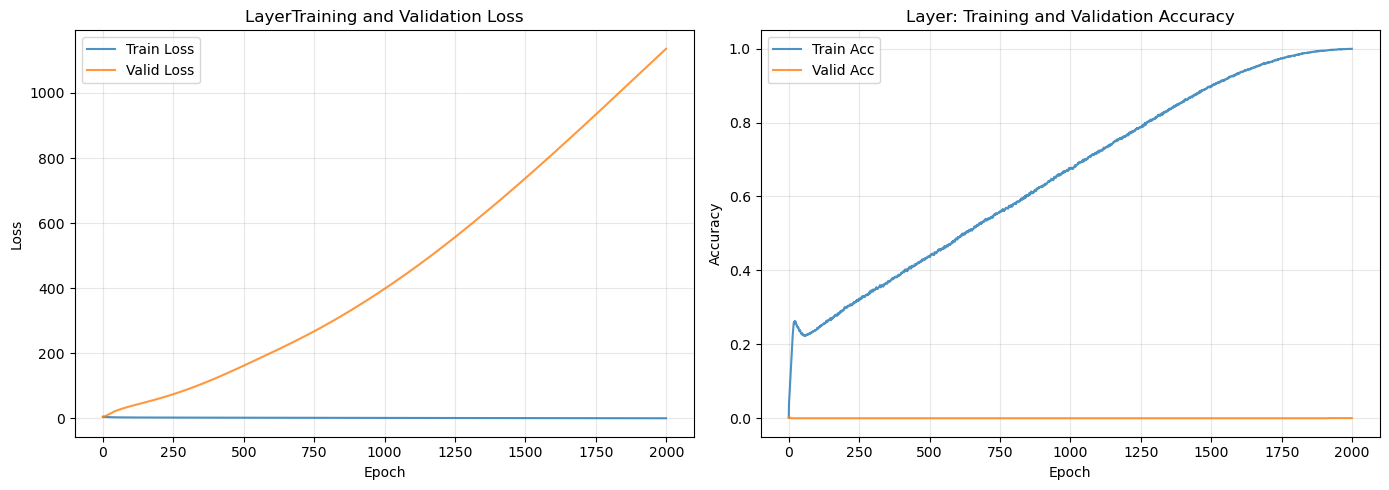

Saved Layer_training_results.png


In [4]:
bi_linear = init_model(ModelConfig)
bi_results = train_loop(bi_linear, loaders, TrainConfig)

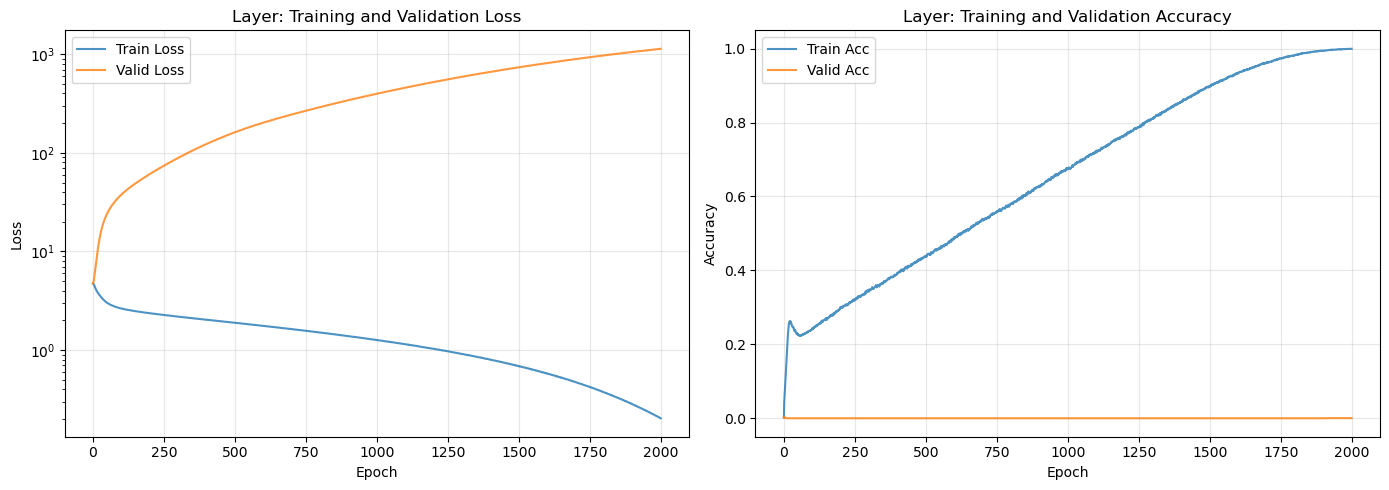

Saved Layer_training_results.png


In [13]:
plot_training_results(bi_results["train_losses"], bi_results["valid_losses"], bi_results["train_accs"], bi_results["valid_accs"], arc = "Layer", y_scale = "log")

In [5]:
# Plotting first few epochs
# plt.plot(range(len(results["valid_accs"][:10])), results["valid_accs"][:10])

# Sanity check n=1
test_point = 1337
pair = pairs[test_point, :]
label = labels[test_point]
one_hot = onehots[test_point, :]
print(f"{pair=}")
print(f"{(pair.sum().item() % DataConfig.P)=}")
print(f"{label=}")
print(f"{torch.argmax(bi_linear(one_hot))=}")

# Memorisation?
total_params = sum(p.numel() for p in bi_linear.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

pair=tensor([11, 94])
(pair.sum().item() % DataConfig.P)=105
label=tensor(105)
torch.argmax(bi_linear(one_hot))=tensor(70)
Total number of parameters: 51076


### Trainig bilinear layer with Projection


Training: 100%|██████████| 400/400 [01:26<00:00,  4.61it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]



Loaded best model with validation loss: 0.0000


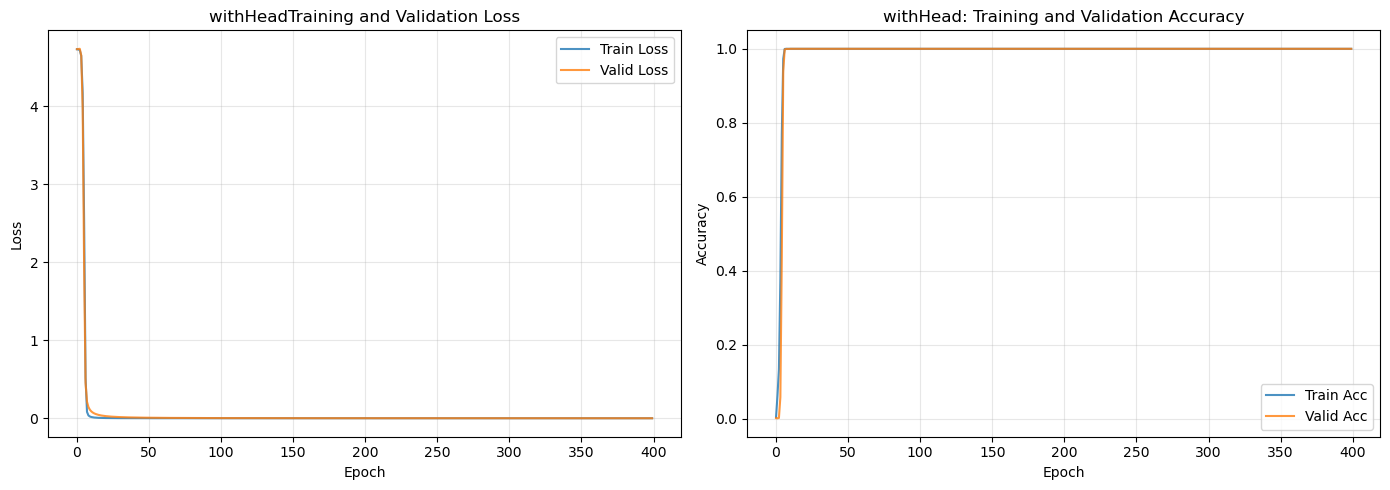

Saved withHead_training_results.png


In [8]:
ModelConfig.d_hidden = DataConfig.P
TrainConfig.epochs = 400

w_projection = init_model(ModelConfig)
p_results = train_loop(w_projection, loaders, TrainConfig)

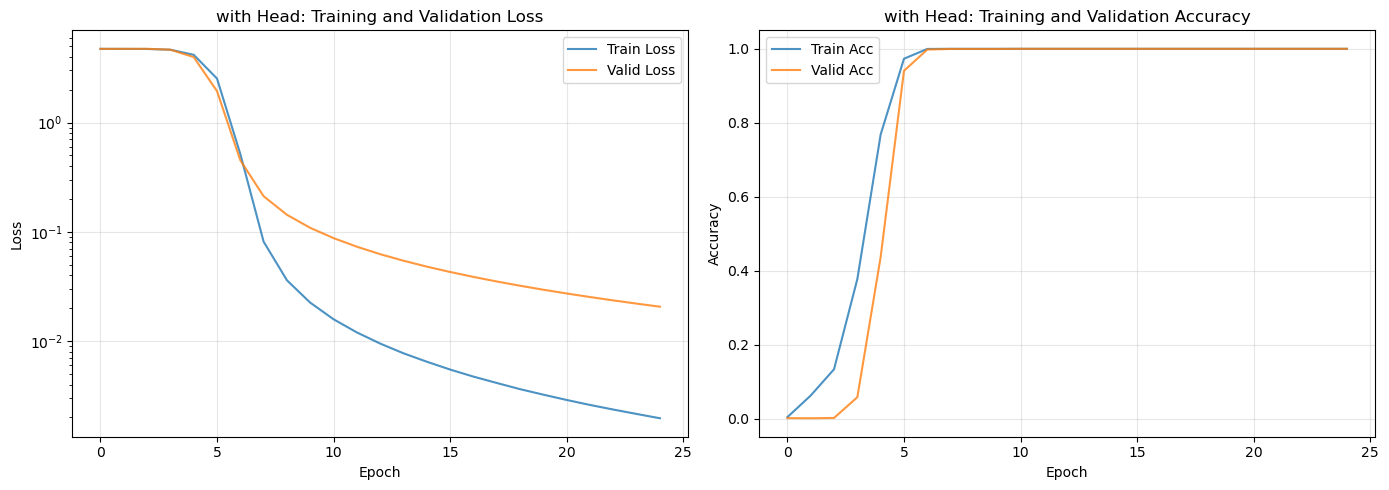

Saved with Head_training_results.png


In [14]:
plot_training_results(p_results["train_losses"], p_results["valid_losses"], p_results["train_accs"], p_results["valid_accs"], 
                      arc = "with Head", y_scale = "log", cut_off_epoch=25)

In [9]:
# Sanity check n=1
test_point = 1337
pair = pairs[test_point, :]
label = labels[test_point]
one_hot = onehots[test_point, :]
print(f"{pair=}")
print(f"{(pair.sum().item() % DataConfig.P)=}")
print(f"{label=}")
print(f"{torch.argmax(w_projection(one_hot))=}")

# Memorisation?
total_params = sum(p.numel() for p in w_projection.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

pair=tensor([11, 94])
(pair.sum().item() % DataConfig.P)=105
label=tensor(105)
torch.argmax(w_projection(one_hot))=tensor(105)
Total number of parameters: 63845


## Interaction Matrices of the Bilinear Layer with Head

In [30]:
# Compute the interaction matrix for a given output dimension
from plotly import express as px
from einops import einsum
import pandas as pd
torch.set_grad_enabled(False)

int_mats = []
eigenvalues_list = []
eigenvectors_list = []
remainders = [0, 5, 22, 42, 66, 99]

for k in remainders:
    q = einsum(w_projection.w_p[k], w_projection.w_l, w_projection.w_r, "hid, hid in1, hid in2 -> in1 in2")

    # Symmetrize the interaction matrix, uncomment for a clean interaction matrix
    # .mT is the transpose of the last two dimensions (which does not matter here but will in the future)
    q = 0.5 * (q + q.mT)
    int_mats.append(q)

    # Compute eigenvectors and eigenvalues of symmetric interaction matrix
    eigenvalues, eigenvectors = torch.linalg.eigh(q)  # eigh for symmetric matrices (more stable)
    
    # Sort by descending eigenvalue magnitude (eigh returns ascending order)
    idx = eigenvalues.abs().argsort(descending=True)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    eigenvalues_list.append(eigenvalues)
    eigenvectors_list.append(eigenvectors)

# Stack for easier manipulation
int_mats = torch.stack(int_mats, dim=0)
eigenvalues_tensor = torch.stack(eigenvalues_list, dim=0)  # [num_remainders, P]
eigenvectors_tensor = torch.stack(eigenvectors_list, dim=0)  # [num_remainders, P, P]

# Visualize interaction matrices
fig = px.imshow(int_mats, color_continuous_midpoint=0, color_continuous_scale="RdBu", facet_col=0)
facet_names = [f"{remainder=}" for remainder in remainders]
for i, ann in enumerate(fig.layout.annotations):
    ann.text = facet_names[i]
fig.show()

# Create a DataFrame for better plotly handling
eigenvalues_df = pd.DataFrame(
    eigenvalues_tensor.numpy().T,  # Transpose so each column is a remainder
    columns=[f"remainder={r}" for r in remainders]
)
eigenvalues_df['Eigenvalue Index'] = eigenvalues_df.index

fig_eig = px.line(
    eigenvalues_df, 
    x='Eigenvalue Index',
    y=[f"remainder={r}" for r in remainders],
    labels={'value': 'Eigenvalue', 'variable': 'Remainder'},
    title='Eigenvalue Spectrum for Each Remainder'
)
fig_eig.update_layout(legend_title_text='Remainder')
fig_eig.show()

# Visualize top eigenvectors (e.g., top 3 for each remainder)
# num_top_eigenvectors = 3
# fig_eigvec, axes = plt.subplots(len(remainders), num_top_eigenvectors, figsize=(15, 3*len(remainders)))
# for i, remainder in enumerate(remainders):
#     for j in range(num_top_eigenvectors):
#         ax = axes[i, j] if len(remainders) > 1 else axes[j]
#         eigvec = eigenvectors_tensor[i, :, j].numpy()
#         ax.plot(eigvec)
#         ax.set_title(f'remainder={remainder}, eigvec {j}\n(λ={eigenvalues_tensor[i, j]:.3f})')
#         ax.set_xlabel('Input dimension')
#         ax.set_ylabel('Component')
#         ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# print(f"Eigenvalues shape: {eigenvalues_tensor.shape}")
# print(f"Eigenvectors shape: {eigenvectors_tensor.shape}")
# print(f"\nTop 5 eigenvalues for each remainder:")
# for i, remainder in enumerate(remainders):
#     print(f"  remainder={remainder}: {eigenvalues_tensor[i, :5].numpy()}")

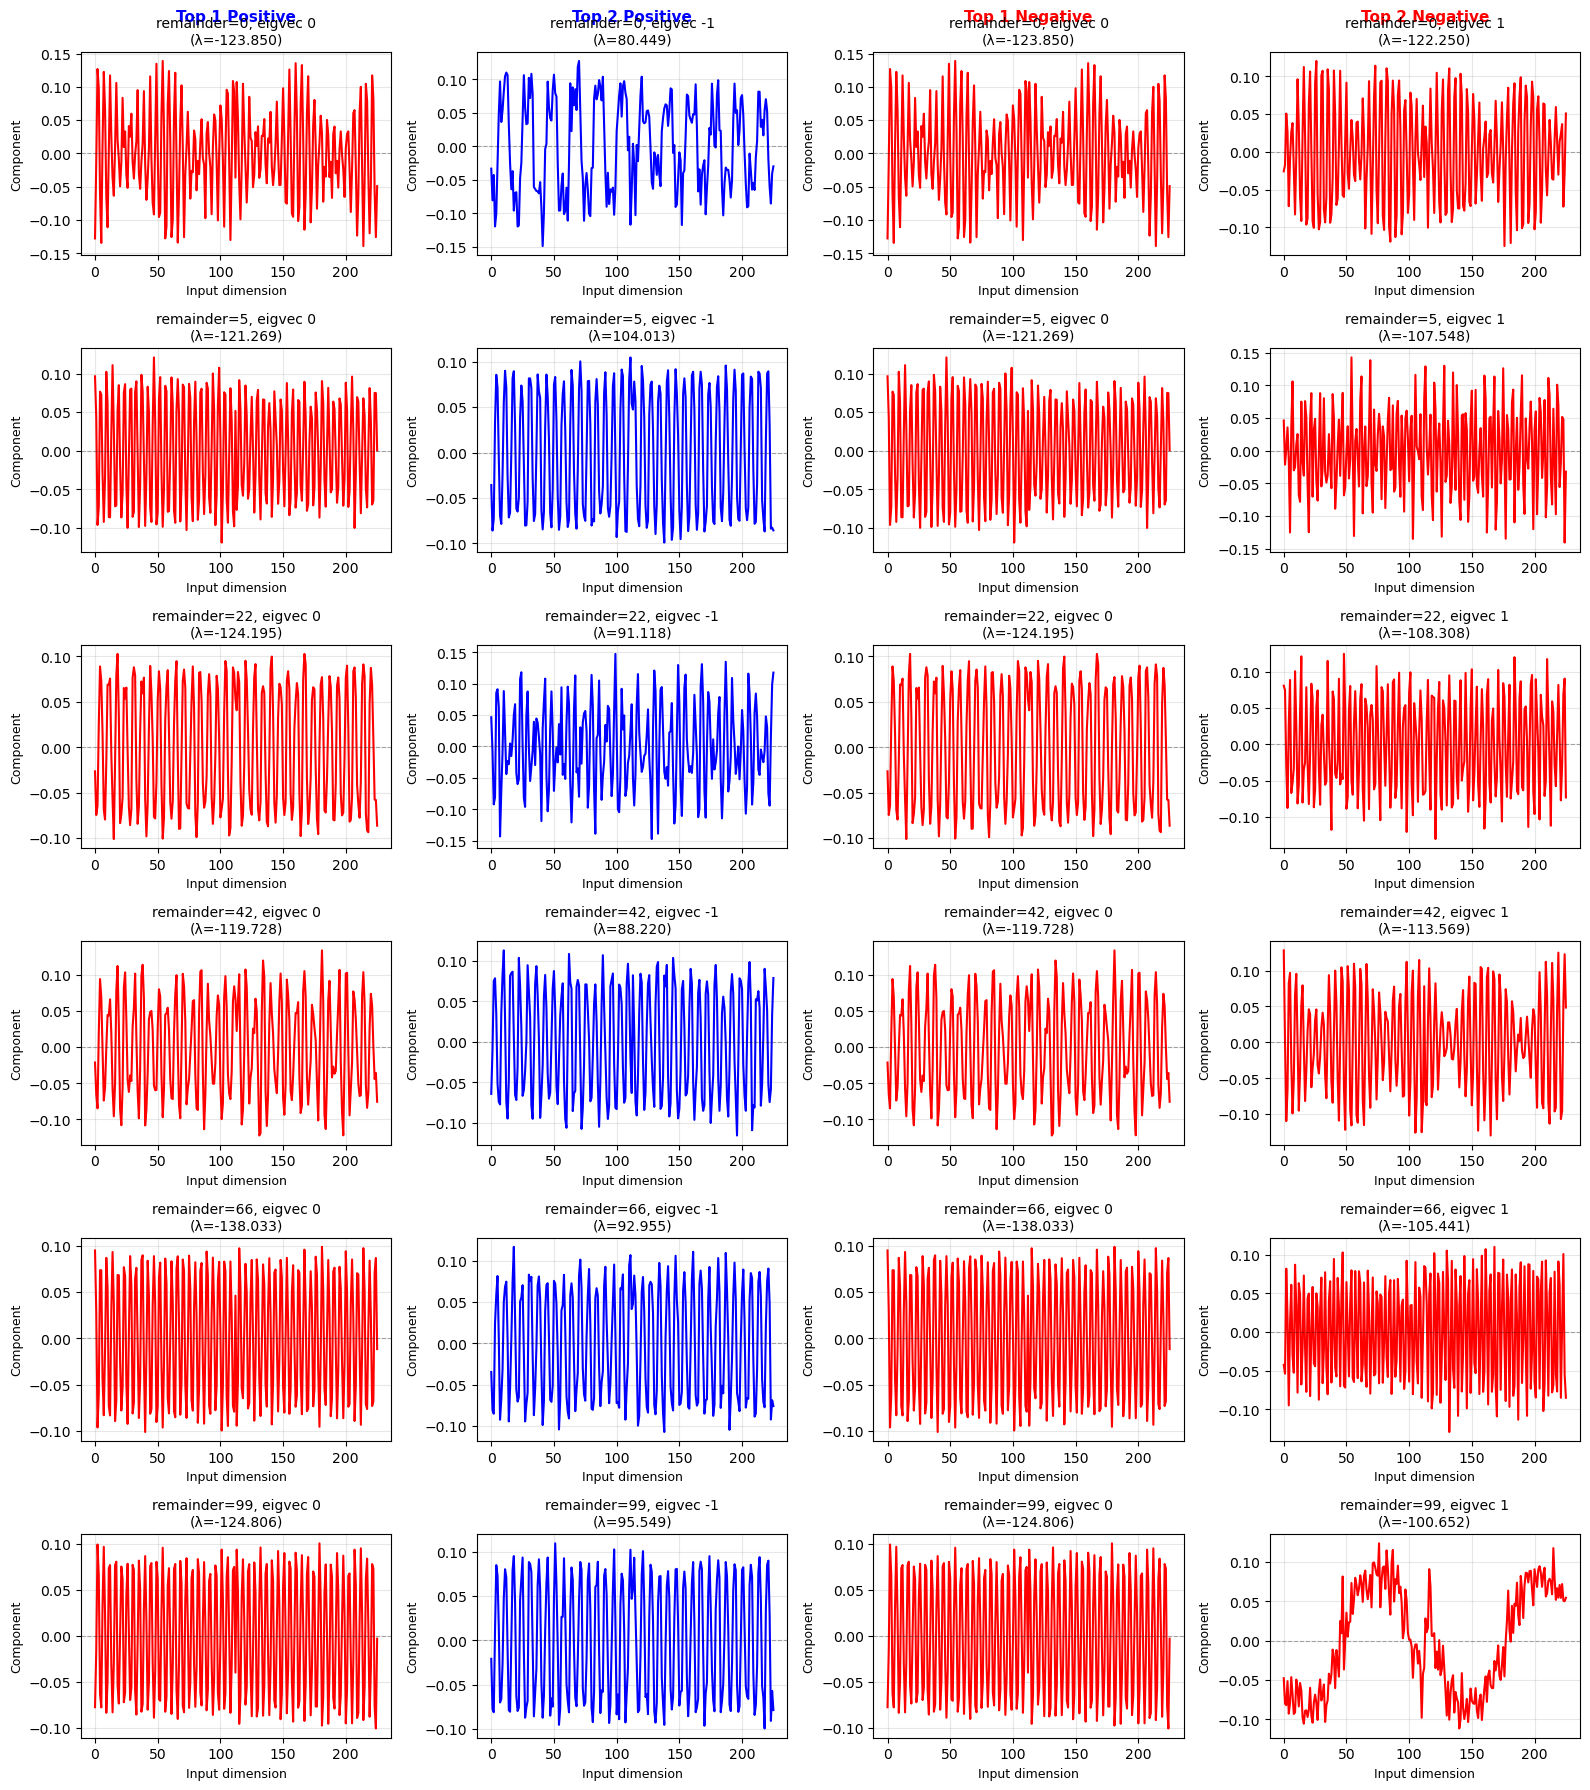


Top 2 positive and top 2 negative eigenvalues for each remainder:
  remainder=0:
    Positive: [75.88253 80.44907]
    Negative: [-123.850334 -122.24999 ]
  remainder=5:
    Positive: [ 82.523575 104.0132  ]
    Negative: [-121.26941  -107.548256]
  remainder=22:
    Positive: [87.54543 91.1177 ]
    Negative: [-124.19493  -108.308075]
  remainder=42:
    Positive: [68.86842  88.219826]
    Negative: [-119.72783 -113.56855]
  remainder=66:
    Positive: [83.69391  92.954895]
    Negative: [-138.03267 -105.44091]
  remainder=99:
    Positive: [90.03828 95.54906]
    Negative: [-124.80603 -100.6524 ]


In [29]:
# Visualize top positive and negative eigenvectors
num_pos = 2  # Top 2 positive eigenvalues
num_neg = 2  # Top 2 negative eigenvalues (most negative)

fig_eigvec, axes = plt.subplots(len(remainders), num_pos + num_neg, figsize=(16, 3*len(remainders)))

for i, remainder in enumerate(remainders):
    # Get indices for top positive and most negative eigenvalues
    eigenvals = eigenvalues_tensor[i].numpy()
    
    # Top positive (already sorted by magnitude, but we want actual values)
    pos_indices = [-j for j in range(num_pos)]
    # Most negative (smallest values)
    neg_indices = [j for j in range(num_neg)]
    
    # Combine: top positive first, then most negative
    selected_indices = pos_indices + neg_indices
    
    for col, j in enumerate(selected_indices):
        ax = axes[i, col] if len(remainders) > 1 else axes[col]
        eigvec = eigenvectors_tensor[i, :, j].numpy()
        
        # Color code: blue for positive eigenvalues, red for negative
        color = 'blue' if eigenvalues_tensor[i, j] > 0 else 'red'
        
        ax.plot(eigvec, color=color, linewidth=1.5)
        ax.set_title(f'remainder={remainder}, eigvec {j}\n(λ={eigenvalues_tensor[i, j]:.3f})', 
                     fontsize=10)
        ax.set_xlabel('Input dimension', fontsize=9)
        ax.set_ylabel('Component', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)

# Add column labels
for col in range(num_pos):
    axes[0, col].text(0.5, 1.15, f'Top {col+1} Positive', 
                      transform=axes[0, col].transAxes,
                      ha='center', fontsize=11, fontweight='bold', color='blue')
for col in range(num_neg):
    axes[0, num_pos + col].text(0.5, 1.15, f'Top {col+1} Negative', 
                                transform=axes[0, num_pos + col].transAxes,
                                ha='center', fontsize=11, fontweight='bold', color='red')

plt.tight_layout()
plt.savefig('eigenvector_components_pos_neg.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTop 2 positive and top 2 negative eigenvalues for each remainder:")
for i, remainder in enumerate(remainders):
    eigenvals = eigenvalues_tensor[i].numpy()
    pos_vals = eigenvals[-2:]
    neg_vals = eigenvals[:2]
    print(f"  remainder={remainder}:")
    print(f"    Positive: {pos_vals}")
    print(f"    Negative: {neg_vals}")